In [11]:
import torch
torch.cuda.empty_cache()
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [5]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt

# 定义加载图像函数（保持原样）
def load_image(img_path, max_size=96, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(max(image.size), max_size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

# 加载内容图像、风格图像（降低图像尺寸）
content = load_image('/mnt/workspace/卷积神经网网络的应用/数据集/rainier.jpg', max_size=96).to('cuda')
style = load_image('/mnt/workspace/卷积神经网网络的应用/数据集/autumn-oak.jpg', shape=content.shape[-2:], max_size=96).to('cuda')

# 定义模型（冻结参数）
vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
for param in vgg.parameters():
    param.requires_grad_(False)
vgg.to('cuda')

# 特征提取函数（保持原样）
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', 
                  '17': 'conv4_1', '19': 'conv4_2', '24': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram矩阵计算（保持原样）
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

# 提取特征和Gram矩阵（保持原样）
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 创建可优化目标图像
target = content.clone().detach().requires_grad_(True).to('cuda')

# 参数设置（调整权重）
style_weights = {'conv1_1': 1., 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e4  # 恢复原始比例（根据实际情况调整）

# 使用Adam优化器（更稳定）
optimizer = optim.Adam([target], lr=0.01)

steps = 1000  # 减少迭代次数测试


images_at_steps = []

for i in range(1, steps+1):
    optimizer.zero_grad()
    target_features = get_features(target, vgg)
    
    # 计算损失
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # 先记录结果
    if i % 100 == 0:
        print(f'Step {i}, Total loss: {total_loss.item():.2f}')
        images_at_steps.append(im_convert(target.clone().detach()))
    
    # 再执行反向传播
    total_loss.backward()
    optimizer.step()
    
    # 只删除占用显存的特征
    del target_features
    torch.cuda.empty_cache()
# 可视化结果（保持原样）
plt.figure(figsize=(10, 5))
for i, img in enumerate(images_at_steps):
    plt.subplot(1, len(images_at_steps), i+1)
    plt.imshow(img)
    plt.title(f'Step {(i+1)*100}')
    plt.axis('off')
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 22.20 GiB of which 113.12 MiB is free. Process 47009 has 22.09 GiB memory in use. Of the allocated memory 21.56 GiB is allocated by PyTorch, and 251.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

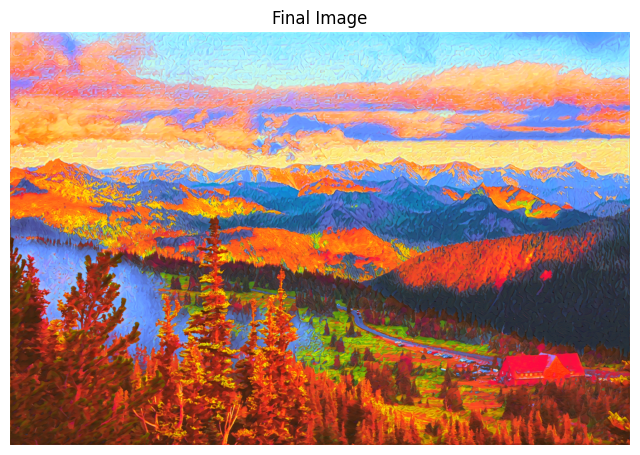

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(images_at_steps[-1])
plt.title('Final Image')
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt

# 定义加载图像函数（保持原样）
def load_image(img_path, max_size=64, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(max(image.size), max_size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

# 加载内容图像、风格图像（降低图像尺寸）
content = load_image('/mnt/workspace/卷积神经网网络的应用/数据集/self-portrait_1998.74.5.jpg', max_size=64).to('cuda')
style = load_image('/mnt/workspace/卷积神经网网络的应用/数据集/Jiliang_dog.jpg', shape=content.shape[-2:], max_size=64).to('cuda')

# 定义模型（冻结参数）
vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
for param in vgg.parameters():
    param.requires_grad_(False)
vgg.to('cuda')

# 特征提取函数（保持原样）
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', 
                  '17': 'conv4_1', '19': 'conv4_2', '24': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram矩阵计算（保持原样）
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

# 提取特征和Gram矩阵（保持原样）
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 创建可优化目标图像
target = content.clone().detach().requires_grad_(True).to('cuda')

# 参数设置（调整权重）
style_weights = {'conv1_1': 1., 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e4  # 恢复原始比例（根据实际情况调整）

# 使用Adam优化器（更稳定）
optimizer = optim.Adam([target], lr=0.01)

steps = 1000  # 减少迭代次数测试


images_at_steps = []

for i in range(1, steps+1):
    optimizer.zero_grad()
    target_features = get_features(target, vgg)
    
    # 计算损失
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # 先记录结果
    if i % 100 == 0:
        print(f'Step {i}, Total loss: {total_loss.item():.2f}')
        images_at_steps.append(im_convert(target.clone().detach()))
    
    # 再执行反向传播
    total_loss.backward()
    optimizer.step()
    
    # 只删除占用显存的特征
    del target_features
    torch.cuda.empty_cache()
# 可视化结果（保持原样）
plt.figure(figsize=(10, 5))
for i, img in enumerate(images_at_steps):
    plt.subplot(1, len(images_at_steps), i+1)
    plt.imshow(img)
    plt.title(f'Step {(i+1)*100}')
    plt.axis('off')
plt.show()